In [100]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import scipy.io
import numpy as np
import glob
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
import os
from PIL import Image
import gc

In [75]:
data = scipy.io.loadmat('G:\\\\capstone files\\\\data\\\\archive (1)\\\\cars_annos.mat')


In [76]:
data.keys()



dict_keys(['__header__', '__version__', '__globals__', 'annotations', 'class_names'])

In [77]:
class_names = pd.DataFrame(data['class_names'])
class_names.head()


,0,1,2,3,4,5,6,7,8,9,...,186,187,188,189,190,191,192,193,194,195
0,[AM General Hummer SUV 2000],[Acura RL Sedan 2012],[Acura TL Sedan 2012],[Acura TL Type-S 2008],[Acura TSX Sedan 2012],[Acura Integra Type R 2001],[Acura ZDX Hatchback 2012],[Aston Martin V8 Vantage Convertible 2012],[Aston Martin V8 Vantage Coupe 2012],[Aston Martin Virage Convertible 2012],...,[Toyota Camry Sedan 2012],[Toyota Corolla Sedan 2012],[Toyota 4Runner SUV 2012],[Volkswagen Golf Hatchback 2012],[Volkswagen Golf Hatchback 1991],[Volkswagen Beetle Hatchback 2012],[Volvo C30 Hatchback 2012],[Volvo 240 Sedan 1993],[Volvo XC90 SUV 2007],[smart fortwo Convertible 2012]


In [78]:
data['annotations']



array([[(array(['car_ims/000001.jpg'], dtype='<U18'), array([[112]], dtype=uint8), array([[7]], dtype=uint8), array([[853]], dtype=uint16), array([[717]], dtype=uint16), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
        (array(['car_ims/000002.jpg'], dtype='<U18'), array([[48]], dtype=uint8), array([[24]], dtype=uint8), array([[441]], dtype=uint16), array([[202]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
        (array(['car_ims/000003.jpg'], dtype='<U18'), array([[7]], dtype=uint8), array([[4]], dtype=uint8), array([[277]], dtype=uint16), array([[180]], dtype=uint8), array([[1]], dtype=uint8), array([[0]], dtype=uint8)),
        ...,
        (array(['car_ims/016183.jpg'], dtype='<U18'), array([[25]], dtype=uint8), array([[32]], dtype=uint8), array([[587]], dtype=uint16), array([[359]], dtype=uint16), array([[196]], dtype=uint8), array([[1]], dtype=uint8)),
        (array(['car_ims/016184.jpg'], dtype='<U18'), array([[56]], dtype=uint8), array([

In [143]:
relative_im_path = pd.DataFrame(data['annotations']['relative_im_path']).transpose()
bbox_x1 = pd.DataFrame(data['annotations']['bbox_x1']).transpose()
bbox_x2 = pd.DataFrame(data['annotations']['bbox_x2']).transpose()
bbox_y1 = pd.DataFrame(data['annotations']['bbox_y1']).transpose()
bbox_y2 = pd.DataFrame(data['annotations']['bbox_y2']).transpose()
class_id = pd.DataFrame(data['annotations']['class']).transpose()
test = pd.DataFrame(data['annotations']['test']).transpose()


In [144]:
annotations = pd.concat([relative_im_path, bbox_x1, bbox_y1, bbox_x2, bbox_y2, class_id, test], axis=1)
annotations.columns = ['relative_im_path', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class_id', 'test']
annotations.head()
#values are in the same order, confirmed through the matlab file using octave

,relative_im_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id,test
0,[car_ims/000001.jpg],[[112]],[[7]],[[853]],[[717]],[[1]],[[0]]
1,[car_ims/000002.jpg],[[48]],[[24]],[[441]],[[202]],[[1]],[[0]]
2,[car_ims/000003.jpg],[[7]],[[4]],[[277]],[[180]],[[1]],[[0]]
3,[car_ims/000004.jpg],[[33]],[[50]],[[197]],[[150]],[[1]],[[0]]
4,[car_ims/000005.jpg],[[5]],[[8]],[[83]],[[58]],[[1]],[[0]]


In [81]:
annotations.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16185 entries, 0 to 16184
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   relative_im_path  16185 non-null  object
 1   bbox_x1           16185 non-null  object
 2   bbox_y1           16185 non-null  object
 3   bbox_x2           16185 non-null  object
 4   bbox_y2           16185 non-null  object
 5   class_id          16185 non-null  object
dtypes: object(6)
memory usage: 758.8+ KB


In [82]:
annotations[annotations.columns.difference(['relative_im_path'])] = annotations[annotations.columns.difference(['relative_im_path'])].astype(int)



In [108]:
annotations

,relative_im_path,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class_id
0,[car_ims/000001.jpg],112,7,853,717,1
1,[car_ims/000002.jpg],48,24,441,202,1
2,[car_ims/000003.jpg],7,4,277,180,1
3,[car_ims/000004.jpg],33,50,197,150,1
4,[car_ims/000005.jpg],5,8,83,58,1
...,...,...,...,...,...,...
16180,[car_ims/016181.jpg],38,36,375,234,196
16181,[car_ims/016182.jpg],29,34,235,164,196
16182,[car_ims/016183.jpg],25,32,587,359,196
16183,[car_ims/016184.jpg],56,60,208,186,196


<AxesSubplot: >

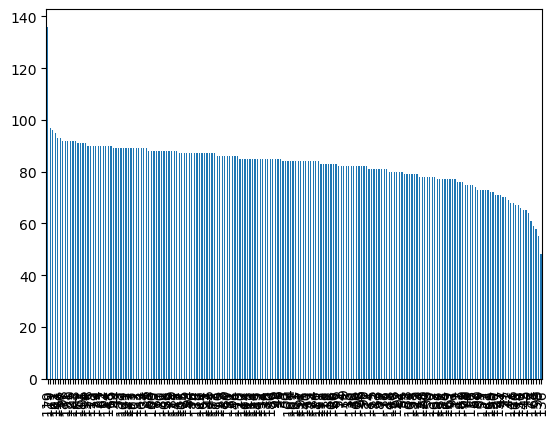

In [84]:
annotations['class_id'].value_counts().plot(kind='bar')
#I know this is not the best way to visualize this data, but I am just trying to get a feel for the data

In [98]:





#get all the images from the folders

In [148]:

gc.collect()


3382

In [149]:

train_image_paths = glob.glob('G:/capstone files/data/archive (1)/cars_train/cars_train/*.jpg')

test_image_paths = glob.glob('G:/capstone files/data/archive (1)/cars_test/cars_test/*.jpg')

#resize all the images to 224x224 and store in local memory to save ram
def save_resized_images(image_paths, output_dir, size=(224, 224)):
    for image_paths in image_paths:
        with Image.open(image_paths) as img:
            resized_img = img.resize(size)
            output_path = os.path.join(output_dir, os.path.basename(image_paths))
            resized_img.save(output_path)
#set the output directories for the resized images
train_output_dir = "G:/capstone files/data/cars train resized"
test_output_dir = "G:/capstone files/data/cars test resized"
#make the directories if they don't exist
if not os.path.exists(train_output_dir):
    os.makedirs(train_output_dir)
if not os.path.exists(test_output_dir):
    os.makedirs(test_output_dir)

save_resized_images(train_image_paths, train_output_dir)
save_resized_images(test_image_paths, test_output_dir)
#resize all the images to 224x224 and store in local memory to save ram


In [151]:
resized_train_image_path = glob.glob(train_output_dir + '/*.jpg')
resized_test_image_path = glob.glob(test_output_dir + '/*.jpg')


In [152]:


def preprocess_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.convert_image_dtype(image, tf.float32)
    return image

train_images = tf.data.Dataset.from_tensor_slices(resized_train_image_path)
train_images = train_images.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_images = tf.data.Dataset.from_tensor_slices(resized_test_image_path)
test_images = test_images.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


In [153]:
# Load the first image in the training set
first_image = list(train_images.take(1))[0]

first_image_shape = first_image.shape
print(first_image_shape)


(224, 224, 3)


In [154]:

train_annotations = annotations.drop(annotations[annotations['test'] == 1].index)
train_annotations.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 8144 entries, 0 to 16144
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   relative_im_path  8144 non-null   object
 1   bbox_x1           8144 non-null   object
 2   bbox_y1           8144 non-null   object
 3   bbox_x2           8144 non-null   object
 4   bbox_y2           8144 non-null   object
 5   class_id          8144 non-null   object
 6   test              8144 non-null   object
dtypes: object(7)
memory usage: 509.0+ KB


In [155]:
test_annotations = annotations.drop(annotations[annotations['test'] == 0].index)
test_annotations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8041 entries, 45 to 16184
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   relative_im_path  8041 non-null   object
 1   bbox_x1           8041 non-null   object
 2   bbox_y1           8041 non-null   object
 3   bbox_x2           8041 non-null   object
 4   bbox_y2           8041 non-null   object
 5   class_id          8041 non-null   object
 6   test              8041 non-null   object
dtypes: object(7)
memory usage: 502.6+ KB
